# Static Analysis

**Static program analysis** is the analysis of computer software performed without executing any programs, in contrast with **dynamic analysis**, which is performed on programs during their execution.

We only focus on binary analysis here, not symbolic analysis.

In [2]:
# @title
import datetime
print(datetime.datetime.now())

2024-04-15 01:25:32.296533


[Wiki] The Portable Executable (PE) format is a file format for executables, object code, DLLs and others used in 32-bit and 64-bit versions of Windows operating systems. The PE format is a data structure that encapsulates the information necessary for the Windows OS loader to manage the wrapped executable code. This includes dynamic library references for linking, API export and import tables, resource management data and local storage data.

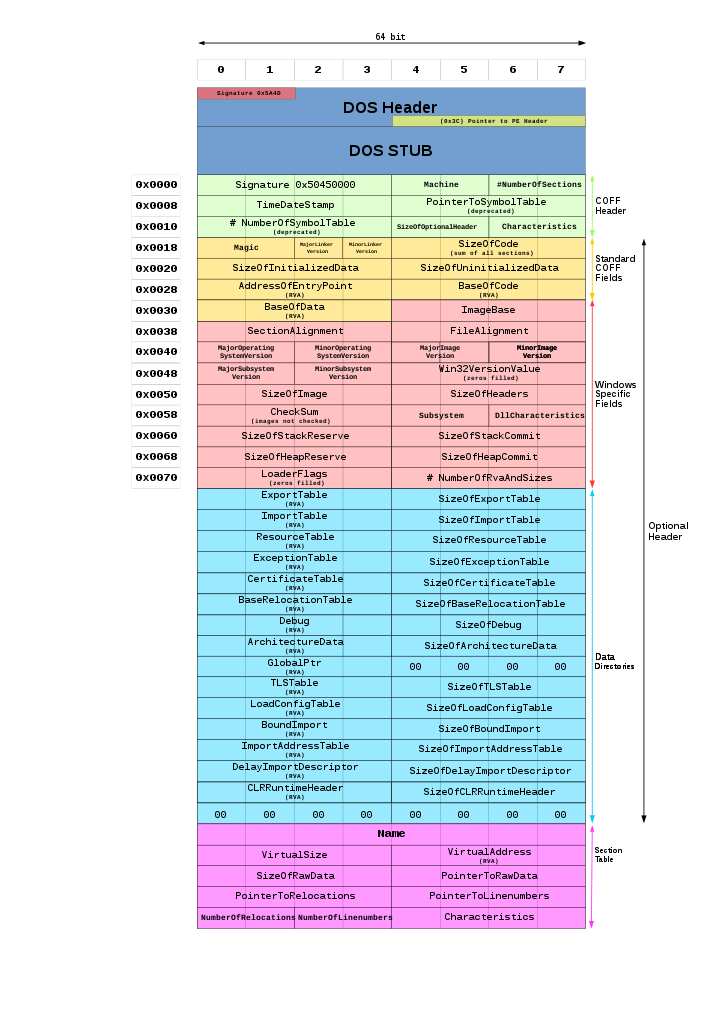

### Get Example Files

In [3]:
# Get a 32-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe -O putty32.exe

--2024-04-15 01:25:41--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe [following]
--2024-04-15 01:25:41--  https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1489184 (1.4M) [application/x-msdos-program]
Saving to: ‘putty32.exe’

putty32.exe         100%[===================>]   1.42M  2.97MB/s    in 0.5s    

2024-04-15 01:25:42 (2.97 MB/s) - ‘putty32.exe’ saved [1489184/1489184]



In [4]:
# Get a 64-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe -O putty64.exe

--2024-04-15 01:25:44--  https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w64/putty.exe [following]
--2024-04-15 01:25:45--  https://the.earth.li/~sgtatham/putty/0.80/w64/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1661216 (1.6M) [application/x-msdos-program]
Saving to: ‘putty64.exe’

putty64.exe         100%[===================>]   1.58M  3.30MB/s    in 0.5s    

2024-04-15 01:25:45 (3.30 MB/s) - ‘putty64.exe’ saved [1661216/1661216]



In [5]:
!ls -al

total 3096
drwxr-xr-x 1 root root    4096 Apr 15 01:25 .
drwxr-xr-x 1 root root    4096 Apr 15 01:24 ..
drwxr-xr-x 4 root root    4096 Apr 11 13:21 .config
-rw-r--r-- 1 root root 1489184 Dec 16 13:19 putty32.exe
-rw-r--r-- 1 root root 1661216 Dec 16 13:19 putty64.exe
drwxr-xr-x 1 root root    4096 Apr 11 13:21 sample_data


### EXE file?

using file extension is a stupid way

In [7]:
def isExe(fp):
    if fp.endswith("exe"):
        return True
    else:
        return False

In [8]:
isExe("putty32.exe")

True

### MZ (DOS) file?

In [9]:
def isMZ(fp):
    with open(fp, 'rb') as hnd:
        if hnd.read(2) == b"MZ":
            return True
        else:
            return False

In [10]:
isMZ("putty32.exe")

True

In [11]:
isMZ("putty64.exe")

True

### PE file?

In [12]:
def isPE(fp):
  try:
    with open(fp, 'rb') as hnd:
      if hnd.read(2) != b"MZ":
        return False
      hnd.seek(0x3c, 0)

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      if hnd.read(4) == b"PE\0\0":
        return True
      else:
        print("isMZ, not PE.")
        return False
  except:
    return False

In [13]:
isPE("/content/putty32.exe")

True

### Architecture? (Machine)

In [14]:
def machine(fp):
  try:
    with open(fp, 'rb') as hnd:
      hnd.seek(0x3c, 0)

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      hnd.read(4)
      machine = struct.unpack("<H", hnd.read(2))[0]

      if machine == 332: # IMAGE_FILE_MACHINE_I386
        return "IA-32 (32-bit x86)"
      elif machine == 512: #IMAGE_FILE_MACHINE_IA64:
        return "IA-64 (Itanium)"
      elif machine == 34404: #IMAGE_FILE_MACHINE_AMD64:
        return "AMD64 (64-bit x86)"
      else:
        return "Unknown architecture"
  except:
    return "Exception"

In [15]:
machine("/content/putty32.exe")

'IA-32 (32-bit x86)'

In [16]:
machine("/content/putty64.exe")

'AMD64 (64-bit x86)'

Microsoft has a mapping table of all machine types and their values. https://docs.microsoft.com/en-us/windows/win32/debug/pe-format

### Hex representation

In [17]:
import binascii

def printHex(fp, limit = 64):
  with open(fp, 'rb') as f:
    content = f.read()

    i = 0
    for b in content:
      print(format(b, "02x"), " ", end="")
      if i% 8 == 7:
        print("")
      i += 1
      if i == limit:
        break

In [18]:
printHex("/content/putty32.exe", limit = 160)

4d  5a  78  00  01  00  00  00  
04  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
40  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  78  00  00  00  
0e  1f  ba  0e  00  b4  09  cd  
21  b8  01  4c  cd  21  54  68  
69  73  20  70  72  6f  67  72  
61  6d  20  63  61  6e  6e  6f  
74  20  62  65  20  72  75  6e  
20  69  6e  20  44  4f  53  20  
6d  6f  64  65  2e  24  00  00  
50  45  00  00  4c  01  08  00  
b9  a2  7d  65  00  00  00  00  
00  00  00  00  e0  00  02  01  
0b  01  0e  00  00  6e  0c  00  
00  ee  09  00  00  00  00  00  


Question: where are the DOS and PE signatures?

### Hash

[Wiki] A hash function is any function that can be used to map data of arbitrary size to fixed-size values. The values returned by a hash function are called hash values, digests, or simply hashes. A good hash function should map the expected inputs as evenly as possible over its output range.

Please watch the video.
https://www.youtube.com/watch?v=l53cqhIPZho

In [19]:
import hashlib

#### MD5 and SHA265

You can check it against with the announced hash values at the end of this page. https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html

In [20]:
filenamepath = "putty32.exe"
md5_value = hashlib.md5(open(filenamepath, 'rb').read()).hexdigest()
print(md5_value)

1575e4f6e0f70b34b4d2ac25a2f3fadf


In [21]:
sha256_value = hashlib.sha256(open(filenamepath, 'rb').read()).hexdigest()
print(sha256_value)

88e0276d9908f308bbe7cb829d1001f520ec69ff0f896e1a290f1fa8b178e468


#### GPG

Check the calculated (GNU Privacy Guard) GPG value against with the value in [PuTTY web page](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html). Google "digital signature" first.

* Signature ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html))
* Public Key ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/keys.html))



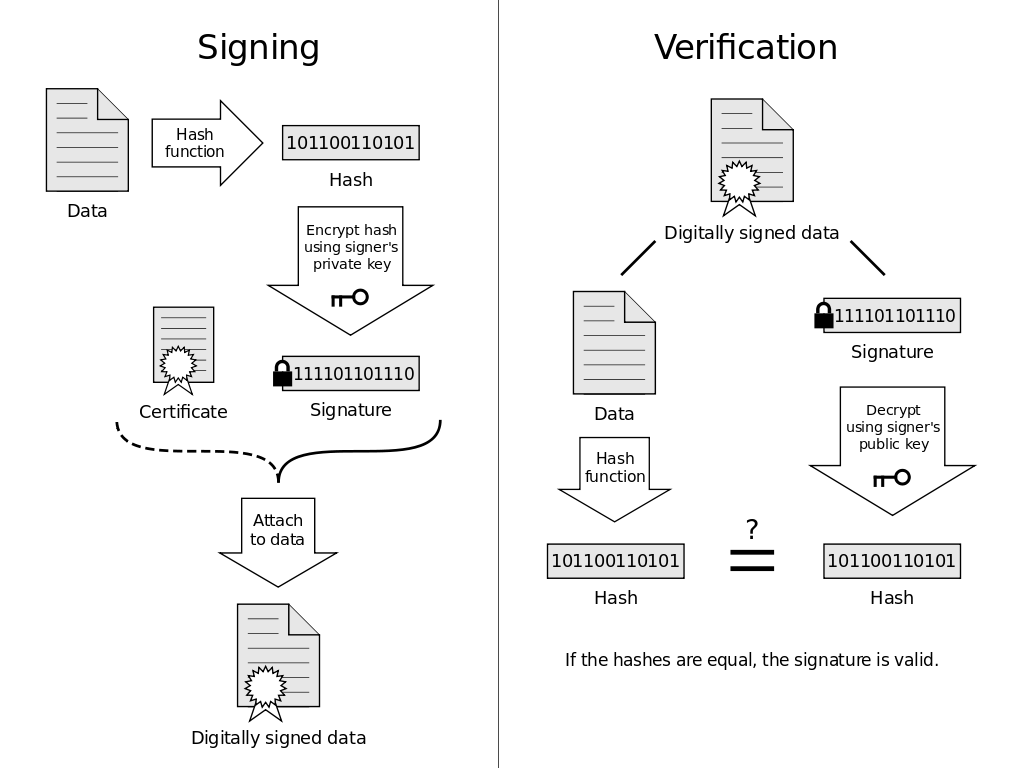

In [22]:
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg

--2024-04-15 01:26:36--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe.gpg [following]
--2024-04-15 01:26:36--  https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe.gpg
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 438 [application/pgp-signature]
Saving to: ‘putty.exe.gpg’

putty.exe.gpg       100%[===================>]     438  --.-KB/s    in 0s      

2024-04-15 01:26:37 (105 MB/s) - ‘putty.exe.gpg’ saved [438/438]



In [23]:
!wget https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2023.asc

--2024-04-15 01:26:38--  https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2023.asc
Resolving www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)... 212.13.197.231, 2001:ba8:1e3::
Connecting to www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)|212.13.197.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2090 (2.0K) [application/pgp-keys]
Saving to: ‘release-2023.asc’

release-2023.asc    100%[===================>]   2.04K  --.-KB/s    in 0s      

2024-04-15 01:26:38 (1.31 GB/s) - ‘release-2023.asc’ saved [2090/2090]



In [24]:
!gpg --import release-2023.asc

gpg: key 1993D21BCAD1AA77: 1 signature not checked due to a missing key
gpg: /root/.gnupg/trustdb.gpg: trustdb created
gpg: key 1993D21BCAD1AA77: public key "PuTTY Releases <putty@projects.tartarus.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: no ultimately trusted keys found


In [25]:
!gpg --verify putty.exe.gpg putty32.exe

gpg: Signature made Mon 18 Dec 2023 02:13:26 PM UTC
gpg:                using RSA key F412BA3AA30FDC0E77B4E3871993D21BCAD1AA77
gpg: Good signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]
gpg: WARNING: This key is not certified with a trusted signature!
gpg:          There is no indication that the signature belongs to the owner.
Primary key fingerprint: F412 BA3A A30F DC0E 77B4  E387 1993 D21B CAD1 AA77


Note: you may need to change the keyname from release-20xx.asc to correct name, since the key may be expired.

# Virustotal

https://www.virustotal.com/gui/home/upload

Try to search 'loadmony', pick one of them and read its info.

# pefile


In [26]:
!pip install pefile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 2.5 MB/s eta 0:00:00


In [27]:
import pefile

### File Type

In [28]:
filenamepath = "putty32.exe"

pef = pefile.PE(filenamepath, fast_load = False)

In [29]:
print(pef.is_dll())
print(pef.is_driver())
print(pef.is_exe())

False
False
True


### Machine, Timestamp, imphash

In [30]:
print(pef.FILE_HEADER.Machine)

332


In [31]:
import time
timestamp = pef.FILE_HEADER.TimeDateStamp
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

2023-12-16 13:14:33


In [32]:
print(pef.get_imphash())

1bcee876dfae5e68c3451c29f9217c72


### Section and Entropy

In [33]:
def printSecEntropy(filenamepath):
  try:
    pef = pefile.PE(filenamepath, fast_load = False)

    total_size = 0
    accumulated_entropy = 0.0

    for sec in pef.sections:
      e = sec.get_entropy()
      m = sec.get_hash_md5()

      print(sec.Name, hex(sec.VirtualAddress), hex(sec.Misc_VirtualSize), sec.SizeOfRawData, e, m)

      accumulated_entropy += sec.SizeOfRawData*e
      total_size += sec.SizeOfRawData
    print('entropy', accumulated_entropy/total_size if total_size !=0 else 'None')
  except:
    print("Error")

In [34]:
printSecEntropy("putty32.exe")

b'.text\x00\x00\x00' 0x1000 0xc6c3a 814592 6.564998062549389 7c0d58b9d7a56230df2daa7e74150bd9
b'.rdata\x00\x00' 0xc8000 0x38ec4 233472 5.693065553278475 e09ae5c1b4d5a58cd16ba1f61dc0edb1
b'.data\x00\x00\x00' 0x101000 0x40d8 3072 2.3398304310066442 c9e17603c1c14cf57daa5e27d0a98278
b'.00cfg\x00\x00' 0x106000 0x8 512 0.06116285224115448 80c010608f3e2c37f435434c4bef7f36
b'.tls\x00\x00\x00\x00' 0x107000 0x9 512 0.0 bf619eac0cdf3f68d496ea9344137e8b
b'.voltbl\x00' 0x108000 0x92 512 2.4564278945748805 03a5735da454908b67301bcd8a21faed
b'.rsrc\x00\x00\x00' 0x109000 0x5ab48 371712 7.826598818837422 2da5cf54a33b0eb7c36872e81d55dc9d
b'.reloc\x00\x00' 0x164000 0xa110 41472 6.697272873049104 672a61881d14b459303ed8beeb3cfcbd
entropy 6.734927079405122


### Packing

Malware sometimes packs itself with packing tool, because it can change its appearance for not being detected by antivirus engine.

A famous packer is UPX (https://en.wikipedia.org/wiki/UPX). Take a look at its [manual file](https://linux.die.net/man/1/upx).

However, these packing tools have "signature" as well. See https://github.com/cuckoosandbox/cuckoo/blob/master/cuckoo/private/peutils/UserDB.TXT

In [35]:
!apt-get install upx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'upx-ucl' instead of 'upx'
The following additional packages will be installed:
  libucl1
The following NEW packages will be installed:
  libucl1 upx-ucl
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 479 kB of archives.
After this operation, 2,176 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libucl1 amd64 1.03+repack-6 [25.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 upx-ucl amd64 3.96-3 [453 kB]
Fetched 479 kB in 0s (2,401 kB/s)
Selecting previously unselected package libucl1:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../libucl1_1.03+repack-6_amd64.deb ...
Unpacking libucl1:amd64 (1.03+repack-6) ...
Selecting previously unselected package upx-ucl.
Preparing to unpack .../upx-ucl_3.96-3_amd64.deb ...
Unpacking u

In [36]:
!upx -o putty32_packed.exe putty32.exe

                       Ultimate Packer for eXecutables
                          Copyright (C) 1996 - 2020
UPX 3.96        Markus Oberhumer, Laszlo Molnar & John Reiser   Jan 23rd 2020

        File size         Ratio      Format      Name
   --------------------   ------   -----------   -----------
   1489184 ->    895264   60.12%    win32/pe     putty32_packed.exe

Packed 1 file.


In [37]:
!ls -al

total 3980
drwxr-xr-x 1 root root    4096 Apr 15 01:27 .
drwxr-xr-x 1 root root    4096 Apr 15 01:24 ..
drwxr-xr-x 4 root root    4096 Apr 11 13:21 .config
-rw-r--r-- 1 root root 1489184 Dec 16 13:19 putty32.exe
-rw-r--r-- 1 root root  895264 Dec 16 13:19 putty32_packed.exe
-rw-r--r-- 1 root root 1661216 Dec 16 13:19 putty64.exe
-rw-r--r-- 1 root root     438 Dec 18 14:13 putty.exe.gpg
-rw-r--r-- 1 root root    2090 Aug  1  2023 release-2023.asc
drwxr-xr-x 1 root root    4096 Apr 11 13:21 sample_data


In [60]:
!hexdump -C putty32_packed.exe |grep -C 1 UPX

*
00000170  55 50 58 30 00 00 00 00  00 30 0a 00 00 10 00 00  |UPX0.....0......|
00000180  00 00 00 00 00 02 00 00  00 00 00 00 00 00 00 00  |................|
00000190  00 00 00 00 80 00 00 e0  55 50 58 31 00 00 00 00  |........UPX1....|
000001a0  00 30 0d 00 00 40 0a 00  00 30 0d 00 00 02 00 00  |.0...@...0......|
--
000001d0  00 20 00 00 00 32 0d 00  00 00 00 00 00 00 00 00  |. ...2..........|
000001e0  00 00 00 00 40 00 00 c0  33 2e 39 36 00 55 50 58  |....@...3.96.UPX|
000001f0  21 0d 09 08 07 03 aa 35  63 39 87 19 ba 61 49 17  |!......5c9...aI.|


In [38]:
print(isPE("putty32_packed.exe"))
print(machine("putty32_packed.exe"))
print(hashlib.md5(open("putty32_packed.exe", 'rb').read()).hexdigest())

True
IA-32 (32-bit x86)
c0400ffc912dcf7e4ea43d7f56b76947


In [39]:
!gpg --verify putty.exe.gpg putty32_packed.exe

gpg: Signature made Mon 18 Dec 2023 02:13:26 PM UTC
gpg:                using RSA key F412BA3AA30FDC0E77B4E3871993D21BCAD1AA77
gpg: BAD signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]


In [40]:
# pip install pefile
import peutils

In [66]:
# get data from github
import requests
def down_github(url, name):
  response = requests.get(url)
  if response.status_code == 200:
    with open('/content/'+name, 'wb') as f:
      f.write(response.content)
  else:
    print('Error: Failed to download the file')

In [71]:
# cockoo does not update the file anymore. It is old as well.
# https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT
# https://github.com/packing-box/pypackerdetect/blob/main/src/pypackerdetect/db/sigs_long.txt

github_url = "https://github.com/packing-box/pypackerdetect/raw/main/src/pypackerdetect/db/sigs_long.txt"

down_github(github_url, 'sigs_long.txt')

In [72]:
# There are some problems in the UserDB.TXT
with open("/content/sigs_long.txt", "rb") as f:
  w = open("UserDB_.TXT", "wb")
  while True:
    line = f.readline()
    if line:
      try:
        line.decode('utf8')
        w.write(line)
      except:
        print("skip", str(line))
    else:
      w.close()
      break

In [73]:
sig_db = peutils.SignatureDatabase("UserDB_.TXT")

matches = sig_db.match(pef)
print("Packed:", matches)

Packed: ['Microsoft Visual C++ 8']


In [74]:
packed_pef = pefile.PE("putty32_packed.exe", fast_load=False)

packed_matches = sig_db.match_all(packed_pef)
print("Packed:", packed_matches)

# Note that the upx packct might be too new for UserDB.TXT to detect!

Packed: [['MSLRH V0.31 -> emadicius'], ['UPX -> www.upx.sourceforge.net']]


In [75]:
printSecEntropy("putty32_packed.exe")

b'UPX0\x00\x00\x00\x00' 0x1000 0xa3000 0 0.0 d41d8cd98f00b204e9800998ecf8427e
b'UPX1\x00\x00\x00\x00' 0xa4000 0xd3000 864256 7.872450079226666 07184ef52ef853d2902cd1e4d3ad05ef
b'.rsrc\x00\x00\x00' 0x177000 0x2000 8192 4.160560506524341 560fa2d2b8671cf61cba2c8795d11f51
entropy 7.837596656008804


Question: what value of entropy is appropriate?

### Libraries

In [51]:
def printLibraries(pef):
  try:
    for entry in pef.DIRECTORY_ENTRY_IMPORT:
      print(entry.dll.decode("ascii"))
      for imp in entry.imports:
        print(" ", imp.name.decode("ascii"), end = "")
      print()
  except Exception as e:
    print('Cannot analysis PE sections', e)

In [52]:
printLibraries(pef)

GDI32.dll
  BitBlt  CreateBitmap  CreateCompatibleBitmap  CreateCompatibleDC  CreateFontA  CreateFontIndirectA  CreatePalette  CreatePen  CreateSolidBrush  DeleteDC  DeleteObject  ExcludeClipRect  ExtTextOutA  ExtTextOutW  GetBkMode  GetCharABCWidthsFloatA  GetCharWidth32A  GetCharWidth32W  GetCharWidthA  GetCharWidthW  GetCharacterPlacementW  GetCurrentObject  GetDIBits  GetDeviceCaps  GetObjectA  GetOutlineTextMetricsA  GetPixel  GetStockObject  GetTextExtentExPointA  GetTextExtentPoint32A  GetTextMetricsA  IntersectClipRect  LineTo  MoveToEx  Polyline  RealizePalette  Rectangle  SelectObject  SelectPalette  SetBkColor  SetBkMode  SetMapMode  SetPaletteEntries  SetPixel  SetTextAlign  SetTextColor  TextOutA  TranslateCharsetInfo  UnrealizeObject  UpdateColors
IMM32.dll
  ImmGetCompositionStringW  ImmGetContext  ImmReleaseContext  ImmSetCompositionFontA  ImmSetCompositionWindow
ole32.dll
  CoCreateInstance  CoInitialize  CoUninitialize
USER32.dll
  AppendMenuA  BeginPaint  CheckDlgBut

Question: Is there any api that looks suspicious? How do you define 'suspicious'?

### String Analysis

In [53]:
import string

print(string.printable)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [57]:
def my_strings(filenamepath, min_strings_len = 16):
  with open(filenamepath, "rb") as fd:
    result = ""
    for b in fd.read():
      c = chr(b)
      if c in string.printable:
        result += c
      else:
        if len(result) >= min_strings_len:
          yield result
        result = ""

In [58]:
list(my_strings("putty32.exe"))

['!This program cannot be run in DOS mode.$',
 '|$41\\$(1\\$p1\\$x1',
 'D$H1D$h1D$T1D$l1D$t3',
 'MNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz@[\\]^_`{',
 '%s Key File Warning',
 'You are loading an SSH-2 private key which has an\nold version of the file format. This means your key\nfile is not fully tamperproof. Future versions of\n%s may stop supporting this private key format,\nso we recommend you convert your key to the new\nformat.\n\nYou can perform this conversion by loading the key\ninto PuTTYgen and then saving it again.',
 'The session log file "%.*s" already exists.\nYou can overwrite it with a new session log,\nappend your session log to the end of it,\nor disable session logging for this session.\nHit Yes to wipe the file, No to append to it,\nor Cancel to disable logging.',
 'CueaaaaceeeiiiAAE**ooouuyOUc$YPsaiounNao?++**!<>###||||++||++++++--|-+||++--|-+----++++++++##||#aBTPEsyt******EN=+><++-=... n2* ',
 ' !cL.Y|S"Ca<--R~o+23\'u|.,1o>///?AAAAAAACEEEEIIIIDNOOOOOxOUUUUYPBaaaaaa

Question: How to improve this function?

### Byte Sequence

In [76]:
def countByte(filenamepath):
  with open(filenamepath, 'rb') as f:
    byte_dict = {i:0 for i in range(256)}
    for i in f.read():
      byte_dict[i] += 1
  return byte_dict

In [77]:
byte_dict = countByte("putty32.exe")

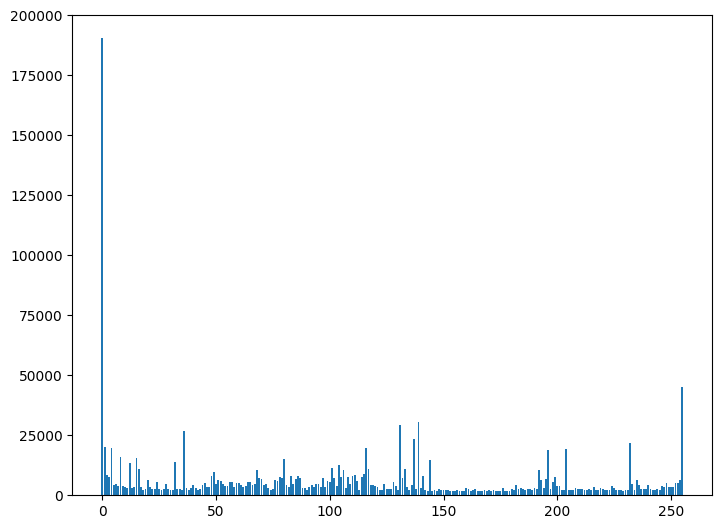

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_dict.values())
plt.show()

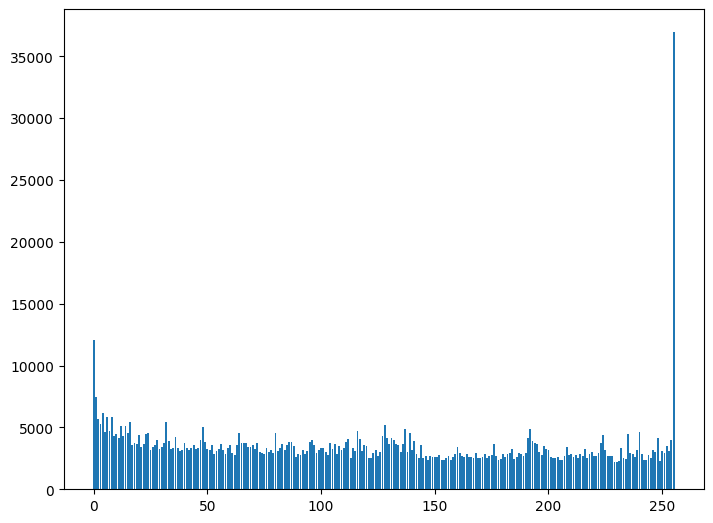

In [79]:
byte_packed_dict = countByte("putty32_packed.exe")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_packed_dict.values())
plt.show()

Question: why? Can you do bi-gram or tri-gram? Need to considering sliding window or not? How many grams needed? Can you find a way to do feature selection on these grams so that we do not need to keep so many features?

Take a look at this website!

https://github.com/packing-box/dataset-packed-pe


### ASM

https://www.capstone-engine.org/lang_python.html

In [80]:
!pip install capstone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.6 MB/s eta 0:00:00


In [83]:
import capstone
import pefile

pef = pefile.PE("putty32.exe")
entryPoint = pef.OPTIONAL_HEADER.AddressOfEntryPoint
data = pef.get_memory_mapped_image()[entryPoint:]
cs = capstone.Cs(capstone.CS_ARCH_X86, capstone.CS_MODE_32)

p = 20
for i in cs.disasm(data, 0x1000):
    print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))
    p -= 1
    if p == 0:
        break

0x1000:	call	0x125b
0x1005:	jmp	0xe84
0x100a:	push	ebp
0x100b:	mov	ebp, esp
0x100d:	push	dword ptr [ebp + 8]
0x1010:	call	0x101f
0x1015:	neg	eax
0x1017:	pop	ecx
0x1018:	sbb	eax, eax
0x101a:	neg	eax
0x101c:	dec	eax
0x101d:	pop	ebp
0x101e:	ret	
0x101f:	push	ebp
0x1020:	mov	ebp, esp
0x1022:	cmp	dword ptr [0x5048d8], -1
0x1029:	push	dword ptr [ebp + 8]
0x102c:	jne	0x1035
0x102e:	call	0xf0c8
0x1033:	jmp	0x1040


Note: we do not cover control-flow graph (CFG)!

## Fuzzy Hash

Get an older version.

In [84]:
!wget https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe -O putty32_old.exe

--2024-04-15 02:00:30--  https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1179880 (1.1M) [application/x-msdos-program]
Saving to: ‘putty32_old.exe’

putty32_old.exe     100%[===================>]   1.12M  2.38MB/s    in 0.5s    

2024-04-15 02:00:31 (2.38 MB/s) - ‘putty32_old.exe’ saved [1179880/1179880]



In [85]:
!apt-get install ssdeep

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ssdeep
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 31.1 kB of archives.
After this operation, 85.0 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ssdeep amd64 2.14.1+git20180629.57fcfff-2 [31.1 kB]
Fetched 31.1 kB in 0s (493 kB/s)
Selecting previously unselected package ssdeep.
(Reading database ... 121773 files and directories currently installed.)
Preparing to unpack .../ssdeep_2.14.1+git20180629.57fcfff-2_amd64.deb ...
Unpacking ssdeep (2.14.1+git20180629.57fcfff-2) ...
Setting up ssdeep (2.14.1+git20180629.57fcfff-2) ...
Processing triggers for man-db (2.10.2-1) ...


In [86]:
!ssdeep putty32.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:B14iA3zopo5mvLsBTQVNaGVQ/ZUpPS2CJDWQeC6WgQhpt8NsIH73yVpZItiaOt+t:cEjEsOUwngQhpilWFI2tO,"/content/putty32.exe"


In [87]:
!ssdeep putty32_old.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:uUqPzwjzLFgyYyAvnPfcBnrF3+Y8HB+g7lpuPv8S:SQ2/BcBnrFOlB3vuPt,"/content/putty32_old.exe"


In [88]:
import hashlib
print(hashlib.md5(open("putty32.exe", 'rb').read()).hexdigest())
print(hashlib.md5(open("putty32_old.exe", 'rb').read()).hexdigest())

1575e4f6e0f70b34b4d2ac25a2f3fadf
a993025aedf905cce301a176f3cd62fb


In [89]:
# https://www.fireeye.com/blog/threat-research/2014/01/tracking-malware-import-hashing.html

print(pefile.PE("putty32.exe").get_imphash())
print(pefile.PE("putty32_old.exe").get_imphash())

1bcee876dfae5e68c3451c29f9217c72
ddf7967f271d2def449d78bf72166fcb


Question: take a look at pefile's source code? What is imphash?

In [90]:
!ssdeep -pb *.exe

Note that python has "ssdeep", but it cannot install in colab directly. https://pypi.org/project/ssdeep/

In [91]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen." > b.txt

In [92]:
!ssdeep b.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF5:hub4gfb4gfb4gfb41,"/content/b.txt"
ssdeep: Did not process files large enough to produce meaningful results


In [93]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pineapple. This is a book and that is a pen" > a.txt

In [94]:
!ssdeep a.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWFIHE3r4FMWFF:hub4gfb4gfb4hb4B,"/content/a.txt"
ssdeep: Did not process files large enough to produce meaningful results
